In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

## 2D case

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    # npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    case_name = "I_20k_fully"
    npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f0.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    
    npy_file_name_aniso_energy = f"p_aveE_fz_fully5d_20k_J1_f0.0_t1.0_refer_1_0_0_seed56689_kt0.66_energy.npy"
    # npy_file_name_aniso_energy = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso) # microstructure
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The I_20k_fully data size is: (201, 2400, 2400, 1)
READING DATA DONE
The I_20k_fully data size is: (201, 2400, 2400, 1)
READING ENERGY DATA DONE


In [4]:
    # GB information
    step_num=121
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/2D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/2D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature with sign
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix)
            else:
                cores = 128
                loop_times = 5
                R = np.zeros((size_x,size_y,3))
                smoothing_class = linear2d.linear_class(size_x,size_y,grain_nums,cores,loop_times,current_microstructure[:,:,0],R,verification_system = False,curvature_sign = True)
                smoothing_class.linear_main("curvature")
                C_ln = smoothing_class.get_C()
                curvature_matrix = C_ln[1,:]
                curvature_matrix_list.append(curvature_matrix)
                # save curvature information
                # np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[i,j]])
                    else:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,-curvature_matrix[i,j]])
                    
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)

100%|██████████| 121/121 [00:00<00:00, 141.69it/s]


In [5]:
    # GB Energy information
    step_num=121
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/2D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GBenergy_information_dict:
                    GBenergy_information_dict[pair_id][0] += 1
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 121/121 [00:01<00:00, 81.77it/s] 


In [6]:
    time_interval = 30
    low_curvature_limit = 0.0182
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    # store all GB point exclude anti-curvature randomness points
    GB_list_velocity_list_exrandom = []
    GB_list_curvature_list_exrandom = []
    # store GB energy point exclude anti_c randomness points
    GB_list_GBenergy_list_exrandom = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_velocity_list_exrandom_tmp = []
        GB_list_curvature_list_exrandom_tmp = []
        GB_list_GBenergy_list_exrandom_tmp = []
        key_set = set()
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            if GB_infomation_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < low_curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
            GB_list_velocity_list_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step][key][4]
            GB_list_curvature_list_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_tmp.append(GBenergy_information_dict_list[time_step][key][4])
            
            # keep anti-curvature GB info
            if current_curvature_value*velocity<-0.0001: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        
        # keep all GBs with GB length larger than 100
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        
        # filter the anti-curvature GB with 00100
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")
        
        # remove exclude data
        if time_step < 2: continue
        for key in tqdm(GB_infomation_dict_list[time_step-2]):
            if GB_infomation_dict_list[time_step-1].get(key) is None: continue
            if GB_infomation_dict_list[time_step-2][key][5] < 100: continue # remove small GBs
            if key in filtered_set: continue # remove the randomness points
            if abs(GB_infomation_dict_list[time_step-2][key][4]) < low_curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step-2][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step-2]==pair_id_pair[0])*(npy_file_aniso[time_step-1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step-2]==pair_id_pair[1])*(npy_file_aniso[time_step-1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step-2][key][5]/2)
            GB_list_velocity_list_exrandom_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step-2][key][4]
            GB_list_curvature_list_exrandom_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_exrandom_tmp.append(GBenergy_information_dict_list[time_step-2][key][4])
        GB_list_velocity_list_exrandom.append(GB_list_velocity_list_exrandom_tmp)
        GB_list_curvature_list_exrandom.append(GB_list_curvature_list_exrandom_tmp)
        GB_list_GBenergy_list_exrandom.append(GB_list_GBenergy_list_exrandom_tmp)
        
    
    # filter the anti-curvature GB with 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)
            
    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])
            

100%|██████████| 22827/22827 [00:00<00:00, 1777997.31it/s]


finish 0 with num of GBs 0, and collected num of GBs 0


100%|██████████| 18853/18853 [00:00<00:00, 89404.67it/s]


finish 1 with num of GBs 8, and collected num of GBs 1


100%|██████████| 16140/16140 [00:00<00:00, 22318.99it/s]


finish 2 with num of GBs 29, and collected num of GBs 13


100%|██████████| 13925/13925 [00:01<00:00, 8701.99it/s]


finish 3 with num of GBs 65, and collected num of GBs 37


100%|██████████| 12041/12041 [00:02<00:00, 4859.63it/s]


finish 4 with num of GBs 101, and collected num of GBs 71


100%|██████████| 10559/10559 [00:03<00:00, 2723.95it/s]


finish 5 with num of GBs 158, and collected num of GBs 117


100%|██████████| 9525/9525 [00:05<00:00, 1875.97it/s]


finish 6 with num of GBs 207, and collected num of GBs 180


100%|██████████| 8611/8611 [00:05<00:00, 1640.49it/s]


finish 7 with num of GBs 214, and collected num of GBs 239


100%|██████████| 7733/7733 [00:05<00:00, 1475.36it/s]


finish 8 with num of GBs 214, and collected num of GBs 295


100%|██████████| 7121/7121 [00:05<00:00, 1243.50it/s]


finish 9 with num of GBs 234, and collected num of GBs 358


100%|██████████| 6582/6582 [00:06<00:00, 1087.23it/s]


finish 10 with num of GBs 247, and collected num of GBs 411


100%|██████████| 6149/6149 [00:05<00:00, 1079.28it/s]


finish 11 with num of GBs 232, and collected num of GBs 470


100%|██████████| 5705/5705 [00:06<00:00, 835.04it/s] 


finish 12 with num of GBs 278, and collected num of GBs 535


100%|██████████| 5334/5334 [00:05<00:00, 925.50it/s] 


finish 13 with num of GBs 234, and collected num of GBs 582


100%|██████████| 5071/5071 [00:05<00:00, 862.28it/s] 


finish 14 with num of GBs 239, and collected num of GBs 634


100%|██████████| 4856/4856 [00:06<00:00, 807.70it/s] 


finish 15 with num of GBs 244, and collected num of GBs 689


100%|██████████| 4562/4562 [00:06<00:00, 725.92it/s] 


finish 16 with num of GBs 255, and collected num of GBs 732


100%|██████████| 4332/4332 [00:06<00:00, 662.66it/s]


finish 17 with num of GBs 265, and collected num of GBs 788


100%|██████████| 4134/4134 [00:05<00:00, 707.55it/s]


finish 18 with num of GBs 238, and collected num of GBs 836


100%|██████████| 3938/3938 [00:05<00:00, 713.95it/s] 


finish 19 with num of GBs 224, and collected num of GBs 886


100%|██████████| 3785/3785 [00:05<00:00, 726.98it/s] 


finish 20 with num of GBs 211, and collected num of GBs 920


100%|██████████| 3672/3672 [00:05<00:00, 719.11it/s]


finish 21 with num of GBs 207, and collected num of GBs 952


100%|██████████| 3524/3524 [00:05<00:00, 649.17it/s]


finish 22 with num of GBs 220, and collected num of GBs 996


100%|██████████| 3373/3373 [00:04<00:00, 749.40it/s]


finish 23 with num of GBs 182, and collected num of GBs 1021


100%|██████████| 3234/3234 [00:05<00:00, 636.10it/s]


finish 24 with num of GBs 206, and collected num of GBs 1055


100%|██████████| 3104/3104 [00:04<00:00, 715.15it/s] 


finish 25 with num of GBs 176, and collected num of GBs 1081


100%|██████████| 2995/2995 [00:04<00:00, 607.50it/s]


finish 26 with num of GBs 200, and collected num of GBs 1117


100%|██████████| 2876/2876 [00:04<00:00, 603.76it/s]


finish 27 with num of GBs 193, and collected num of GBs 1148


100%|██████████| 2788/2788 [00:04<00:00, 650.44it/s]


finish 28 with num of GBs 174, and collected num of GBs 1176


100%|██████████| 2709/2709 [00:03<00:00, 696.91it/s]


finish 29 with num of GBs 158, and collected num of GBs 1207


100%|██████████| 2641/2641 [00:04<00:00, 653.54it/s]


finish 30 with num of GBs 164, and collected num of GBs 1226


100%|██████████| 2546/2546 [00:03<00:00, 662.90it/s]


finish 31 with num of GBs 153, and collected num of GBs 1246


100%|██████████| 2486/2486 [00:04<00:00, 615.57it/s]


finish 32 with num of GBs 160, and collected num of GBs 1270


100%|██████████| 2423/2423 [00:03<00:00, 610.86it/s]


finish 33 with num of GBs 158, and collected num of GBs 1291


100%|██████████| 2374/2374 [00:03<00:00, 688.43it/s]


finish 34 with num of GBs 140, and collected num of GBs 1309


100%|██████████| 2287/2287 [00:03<00:00, 653.22it/s]


finish 35 with num of GBs 142, and collected num of GBs 1331


100%|██████████| 2245/2245 [00:03<00:00, 654.47it/s]


finish 36 with num of GBs 139, and collected num of GBs 1348


100%|██████████| 2177/2177 [00:03<00:00, 632.16it/s]


finish 37 with num of GBs 140, and collected num of GBs 1366


100%|██████████| 2144/2144 [00:02<00:00, 725.69it/s]


finish 38 with num of GBs 120, and collected num of GBs 1388


100%|██████████| 2112/2112 [00:03<00:00, 634.76it/s]


finish 39 with num of GBs 135, and collected num of GBs 1406


100%|██████████| 2063/2063 [00:03<00:00, 687.12it/s]


finish 40 with num of GBs 122, and collected num of GBs 1428


100%|██████████| 2021/2021 [00:03<00:00, 622.14it/s]


finish 41 with num of GBs 132, and collected num of GBs 1452


100%|██████████| 1981/1981 [00:03<00:00, 649.11it/s]


finish 42 with num of GBs 124, and collected num of GBs 1468


100%|██████████| 1935/1935 [00:03<00:00, 644.61it/s]


finish 43 with num of GBs 122, and collected num of GBs 1480


100%|██████████| 1905/1905 [00:03<00:00, 574.56it/s]


finish 44 with num of GBs 132, and collected num of GBs 1493


100%|██████████| 1877/1877 [00:02<00:00, 659.52it/s]


finish 45 with num of GBs 113, and collected num of GBs 1507


100%|██████████| 1852/1852 [00:02<00:00, 767.71it/s]


finish 46 with num of GBs 96, and collected num of GBs 1512


100%|██████████| 1803/1803 [00:02<00:00, 634.92it/s]


finish 47 with num of GBs 113, and collected num of GBs 1529


100%|██████████| 1769/1769 [00:02<00:00, 649.00it/s]


finish 48 with num of GBs 108, and collected num of GBs 1538


100%|██████████| 1745/1745 [00:02<00:00, 646.74it/s]


finish 49 with num of GBs 107, and collected num of GBs 1552


100%|██████████| 1686/1686 [00:02<00:00, 728.89it/s]


finish 50 with num of GBs 92, and collected num of GBs 1563


100%|██████████| 1646/1646 [00:02<00:00, 662.79it/s]


finish 51 with num of GBs 100, and collected num of GBs 1574


100%|██████████| 1618/1618 [00:02<00:00, 651.07it/s]


finish 52 with num of GBs 101, and collected num of GBs 1590


100%|██████████| 1589/1589 [00:02<00:00, 767.44it/s]


finish 53 with num of GBs 84, and collected num of GBs 1605


100%|██████████| 1563/1563 [00:02<00:00, 765.89it/s]


finish 54 with num of GBs 83, and collected num of GBs 1615


100%|██████████| 1553/1553 [00:02<00:00, 769.48it/s]


finish 55 with num of GBs 82, and collected num of GBs 1622


100%|██████████| 1533/1533 [00:02<00:00, 700.57it/s]


finish 56 with num of GBs 89, and collected num of GBs 1624


100%|██████████| 1510/1510 [00:01<00:00, 808.75it/s]


finish 57 with num of GBs 76, and collected num of GBs 1631


100%|██████████| 1476/1476 [00:01<00:00, 801.42it/s]


finish 58 with num of GBs 75, and collected num of GBs 1639


100%|██████████| 1447/1447 [00:01<00:00, 979.36it/s] 


finish 59 with num of GBs 60, and collected num of GBs 1643


100%|██████████| 1430/1430 [00:01<00:00, 765.74it/s]


finish 60 with num of GBs 76, and collected num of GBs 1651


100%|██████████| 1394/1394 [00:01<00:00, 787.55it/s]


finish 61 with num of GBs 72, and collected num of GBs 1663


100%|██████████| 1374/1374 [00:01<00:00, 707.10it/s]


finish 62 with num of GBs 79, and collected num of GBs 1673


100%|██████████| 1354/1354 [00:01<00:00, 809.71it/s]


finish 63 with num of GBs 68, and collected num of GBs 1684


100%|██████████| 1336/1336 [00:01<00:00, 789.09it/s]


finish 64 with num of GBs 69, and collected num of GBs 1687


100%|██████████| 1326/1326 [00:01<00:00, 817.88it/s]


finish 65 with num of GBs 66, and collected num of GBs 1694


100%|██████████| 1309/1309 [00:01<00:00, 692.01it/s]


finish 66 with num of GBs 77, and collected num of GBs 1703


100%|██████████| 1289/1289 [00:01<00:00, 680.88it/s]


finish 67 with num of GBs 77, and collected num of GBs 1714


100%|██████████| 1282/1282 [00:01<00:00, 802.27it/s]


finish 68 with num of GBs 65, and collected num of GBs 1722


100%|██████████| 1263/1263 [00:01<00:00, 723.18it/s]


finish 69 with num of GBs 71, and collected num of GBs 1733


100%|██████████| 1246/1246 [00:01<00:00, 875.74it/s]


finish 70 with num of GBs 58, and collected num of GBs 1739


100%|██████████| 1233/1233 [00:01<00:00, 838.90it/s] 


finish 71 with num of GBs 60, and collected num of GBs 1745


100%|██████████| 1213/1213 [00:01<00:00, 657.50it/s]


finish 72 with num of GBs 75, and collected num of GBs 1754


100%|██████████| 1201/1201 [00:01<00:00, 640.87it/s]


finish 73 with num of GBs 76, and collected num of GBs 1758


100%|██████████| 1179/1179 [00:01<00:00, 597.75it/s]


finish 74 with num of GBs 80, and collected num of GBs 1770


100%|██████████| 1150/1150 [00:01<00:00, 994.98it/s]


finish 75 with num of GBs 47, and collected num of GBs 1774


100%|██████████| 1137/1137 [00:01<00:00, 781.79it/s]


finish 76 with num of GBs 59, and collected num of GBs 1782


100%|██████████| 1112/1112 [00:01<00:00, 781.51it/s]


finish 77 with num of GBs 58, and collected num of GBs 1788


100%|██████████| 1112/1112 [00:01<00:00, 676.77it/s]


finish 78 with num of GBs 67, and collected num of GBs 1793


100%|██████████| 1097/1097 [00:01<00:00, 658.39it/s]


finish 79 with num of GBs 68, and collected num of GBs 1804


100%|██████████| 1086/1086 [00:01<00:00, 725.62it/s]


finish 80 with num of GBs 61, and collected num of GBs 1808


100%|██████████| 1065/1065 [00:01<00:00, 678.41it/s]


finish 81 with num of GBs 64, and collected num of GBs 1816


100%|██████████| 1047/1047 [00:01<00:00, 664.51it/s]


finish 82 with num of GBs 64, and collected num of GBs 1821


100%|██████████| 1047/1047 [00:01<00:00, 943.67it/s]


finish 83 with num of GBs 45, and collected num of GBs 1826


100%|██████████| 1031/1031 [00:01<00:00, 790.23it/s]


finish 84 with num of GBs 53, and collected num of GBs 1834


100%|██████████| 1022/1022 [00:01<00:00, 882.82it/s]


finish 85 with num of GBs 47, and collected num of GBs 1837


100%|██████████| 1015/1015 [00:01<00:00, 763.57it/s]


finish 86 with num of GBs 54, and collected num of GBs 1840


100%|██████████| 1003/1003 [00:01<00:00, 769.18it/s]


finish 87 with num of GBs 53, and collected num of GBs 1846


100%|██████████| 983/983 [00:01<00:00, 688.02it/s]


finish 88 with num of GBs 58, and collected num of GBs 1857


100%|██████████| 962/962 [00:01<00:00, 868.63it/s]


finish 89 with num of GBs 45, and collected num of GBs 1863


100%|██████████| 949/949 [00:01<00:00, 898.76it/s] 


finish 90 with num of GBs 43, and collected num of GBs 1868


100%|██████████| 932/932 [00:01<00:00, 771.92it/s] 


finish 91 with num of GBs 49, and collected num of GBs 1871


100%|██████████| 926/926 [00:01<00:00, 898.64it/s] 


finish 92 with num of GBs 42, and collected num of GBs 1873


100%|██████████| 923/923 [00:00<00:00, 1106.37it/s]


finish 93 with num of GBs 34, and collected num of GBs 1874


100%|██████████| 902/902 [00:01<00:00, 852.84it/s]


finish 94 with num of GBs 43, and collected num of GBs 1876


100%|██████████| 893/893 [00:01<00:00, 787.90it/s] 


finish 95 with num of GBs 46, and collected num of GBs 1887


100%|██████████| 880/880 [00:00<00:00, 894.68it/s] 


finish 96 with num of GBs 40, and collected num of GBs 1892


100%|██████████| 880/880 [00:00<00:00, 916.17it/s] 


finish 97 with num of GBs 39, and collected num of GBs 1897


100%|██████████| 877/877 [00:01<00:00, 773.52it/s] 


finish 98 with num of GBs 46, and collected num of GBs 1904


100%|██████████| 869/869 [00:00<00:00, 881.84it/s]


finish 99 with num of GBs 40, and collected num of GBs 1906


100%|██████████| 870/870 [00:01<00:00, 823.44it/s] 


finish 100 with num of GBs 43, and collected num of GBs 1910


100%|██████████| 853/853 [00:00<00:00, 962.71it/s] 


finish 101 with num of GBs 36, and collected num of GBs 1913


100%|██████████| 847/847 [00:00<00:00, 983.79it/s] 


finish 102 with num of GBs 35, and collected num of GBs 1917


100%|██████████| 833/833 [00:00<00:00, 1164.12it/s]


finish 103 with num of GBs 29, and collected num of GBs 1918


100%|██████████| 835/835 [00:01<00:00, 807.31it/s]


finish 104 with num of GBs 42, and collected num of GBs 1921


100%|██████████| 835/835 [00:00<00:00, 1541.70it/s]


finish 105 with num of GBs 22, and collected num of GBs 1925


100%|██████████| 816/816 [00:00<00:00, 873.19it/s] 


finish 106 with num of GBs 38, and collected num of GBs 1927


100%|██████████| 805/805 [00:01<00:00, 663.91it/s]


finish 107 with num of GBs 44, and collected num of GBs 1930


100%|██████████| 807/807 [00:00<00:00, 861.73it/s]


finish 108 with num of GBs 34, and collected num of GBs 1933


100%|██████████| 796/796 [00:00<00:00, 902.83it/s] 


finish 109 with num of GBs 32, and collected num of GBs 1939


100%|██████████| 789/789 [00:01<00:00, 651.89it/s]


finish 110 with num of GBs 44, and collected num of GBs 1946


100%|██████████| 791/791 [00:00<00:00, 973.80it/s] 


finish 111 with num of GBs 33, and collected num of GBs 1948


100%|██████████| 787/787 [00:00<00:00, 863.94it/s] 


finish 112 with num of GBs 37, and collected num of GBs 1952


100%|██████████| 777/777 [00:00<00:00, 1089.83it/s]


finish 113 with num of GBs 29, and collected num of GBs 1954


100%|██████████| 772/772 [00:01<00:00, 764.29it/s]


finish 114 with num of GBs 41, and collected num of GBs 1957


100%|██████████| 758/758 [00:01<00:00, 732.97it/s]


finish 115 with num of GBs 42, and collected num of GBs 1962


100%|██████████| 753/753 [00:00<00:00, 910.33it/s] 


finish 116 with num of GBs 30, and collected num of GBs 1967


100%|██████████| 746/746 [00:00<00:00, 901.75it/s] 


finish 117 with num of GBs 30, and collected num of GBs 1968


100%|██████████| 733/733 [00:00<00:00, 758.68it/s] 


finish 118 with num of GBs 35, and collected num of GBs 1968


100%|██████████| 730/730 [00:00<00:00, 828.16it/s] 


finish 119 with num of GBs 32, and collected num of GBs 1968


100%|██████████| 746/746 [00:00<00:00, 965.41it/s] 


In [7]:
    time_interval = 30
    # GB_list_velocity_list = []
    GB_antic_list_velocity_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_id_unfocus_lowE_detail = dict()
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        for key in tqdm(GBenergy_information_dict_list[time_step]):
            if GBenergy_information_dict_list[time_step+1].get(key) is None: continue
            if GBenergy_information_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < low_curvature_limit: continue # remove low curvature
            
            # keep the GB with low energy and curvature behavior
            if (GBenergy_information_dict_list[time_step][key][4]<0.4) and (key not in GB_id_focus_detail): # do we need to remove random here?
                if key in GB_id_unfocus_lowE_detail:
                    GB_id_unfocus_lowE_detail[key].append(time_step)
                else:
                    GB_id_unfocus_lowE_detail[key] = [time_step]
            
            # anti-curvature behavior list
            if (key in GB_id_focus_detail) and (time_step in GB_id_focus_detail[key]):
                # Calculate dV
                pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
                # correct the sign of velocity
                current_curvature_value = GB_infomation_dict_list[time_step][key][4]
                if current_curvature_value < 0: GB_antic_list_velocity_list.append(-velocity)
                else: GB_antic_list_velocity_list.append(velocity)
                
                GB_antic_list_GBenergy_list.append(GBenergy_information_dict_list[time_step][key][4])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
            
        
            

100%|██████████| 730/730 [00:00<00:00, 1074707.59it/s]


In [8]:
    total_GB = set()
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB = total_GB | step_GB

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_id_focus.values())}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_id_focus.values())/len(total_GB)*100}% in {len(total_GB)} GBs")
    print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 293
The ratio of anti-curvature GBs during whole simulations is 0.5474998131399955% in 53516 GBs
dict_values([2, 2, 2, 3, 3, 5, 2, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 5, 3, 3, 3, 2, 2, 4, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 2, 2, 2, 2, 2, 4, 2, 6, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 5, 4, 7, 6, 2, 6, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 6, 2, 3, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2

<Figure size 432x288 with 0 Axes>

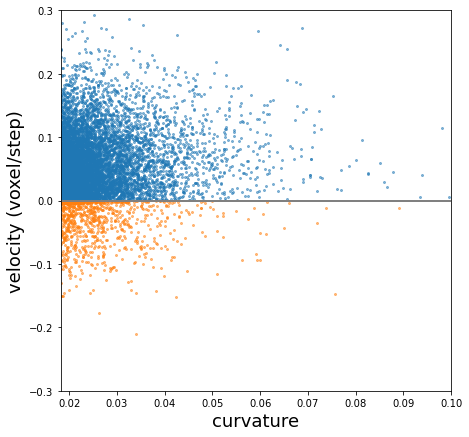

<Figure size 432x288 with 0 Axes>

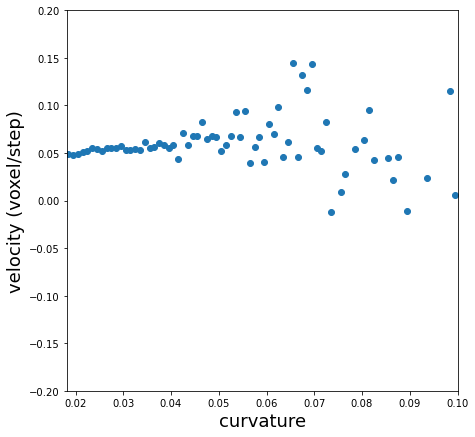

In [13]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    # GBenergy_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        # GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
    curvature_1Dlist_exrandom_remove_0step = []
    velocity_1Dlist_exrandom_remove_0step = []
    # GBenergy_1Dlist_exrandom_remove_0step = []
    for i in range(0,len(GB_list_velocity_list_exrandom)): 
        curvature_1Dlist_exrandom_remove_0step.extend(GB_list_curvature_list_exrandom[i])
        velocity_1Dlist_exrandom_remove_0step.extend(GB_list_velocity_list_exrandom[i])
        # GBenergy_1Dlist_exrandom_remove_0step.extend(GB_list_GBenergy_list_exrandom[i])
    
    # ignore the sign of curvature
    for i in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if curvature_1Dlist_exrandom_remove_0step[i]<0: 
            curvature_1Dlist_exrandom_remove_0step[i] = - curvature_1Dlist_exrandom_remove_0step[i]
            velocity_1Dlist_exrandom_remove_0step[i] = - velocity_1Dlist_exrandom_remove_0step[i]
    velocity_1Dlist_exrandom_remove_0step = np.array(velocity_1Dlist_exrandom_remove_0step)
    curvature_1Dlist_exrandom_remove_0step = np.array(curvature_1Dlist_exrandom_remove_0step)
            
    figure_name_all = f"figures/2D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.plot([low_curvature_limit,0.1],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0],s=4,alpha=0.5)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0],s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([low_curvature_limit,0.1])
    plt.ylim([-0.3,0.3])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if abs(curvature_1Dlist_exrandom_remove_0step[index])>0.1: continue
        curvature_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([low_curvature_limit,0.1])
    plt.ylim([-0.2,0.2])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


Text(0, 0.5, 'num of sites')

<Figure size 432x288 with 0 Axes>

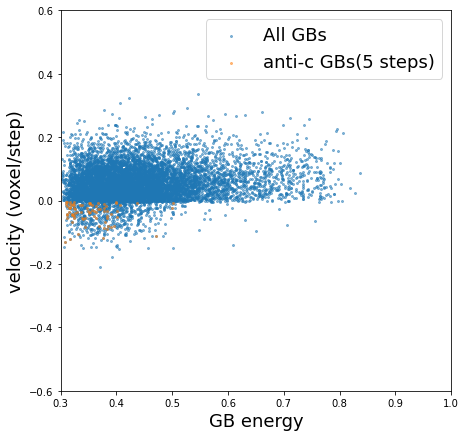

<Figure size 432x288 with 0 Axes>

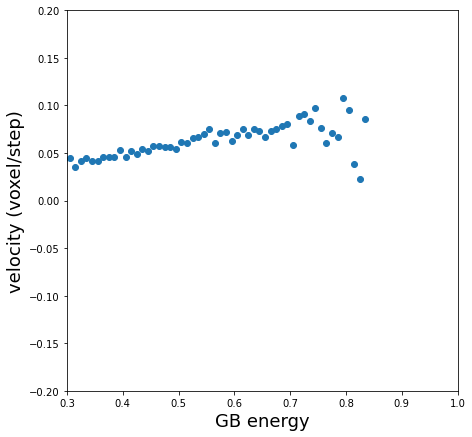

<Figure size 432x288 with 0 Axes>

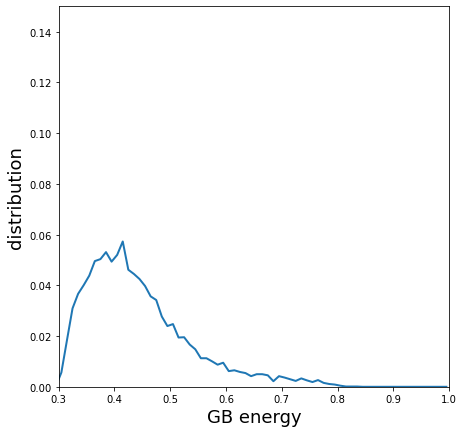

<Figure size 432x288 with 0 Axes>

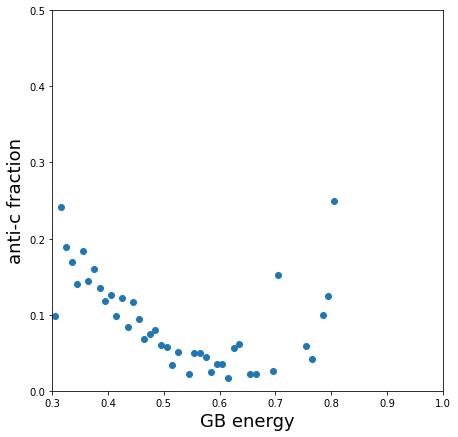

<Figure size 432x288 with 0 Axes>

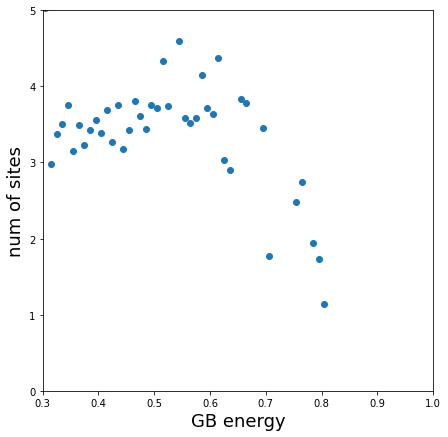

In [12]:

    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_exrandom_remove_0step)):
        if abs(GBenergy_1Dlist_exrandom_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
        if velocity_1Dlist_exrandom_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_exrandom_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/2D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of sites", fontsize=18)
        


In [ ]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/2D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        bin_number = int(1.2/bin_interval)
        curvature_coordinate = np.arange(-0.6,0.6,bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>0.6: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/2D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

In [ ]:
# Get more information for a focus GB

key_focus = 0
for key in GB_id_focus:
    if GB_id_focus[key] == 19: 
        print(f"The longest anti-curvature behavior is {key} with steps {GB_id_focus[key]}")
        key_focus = key
        # break

v_focus = []
c_focus = []
for time_step in range(0,step_num):
    if key_focus in GB_infomation_dict_list[time_step]:
        # Calculate dV
        pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
        
        # make curvature always opposite
        if current_curvature_value<0: 
            current_curvature_value = -current_curvature_value
            velocity = -velocity
        
        # store v-c for a focus GB
        v_focus.append(velocity)
        c_focus.append(current_curvature_value)
        
        if current_curvature_value*velocity<-0.00 and GB_infomation_dict_list[time_step][key_focus][5]>=100: 
            print(f"The anti-curvature step {time_step} has velocity - {round(velocity,3)} and curvature - {round(current_curvature_value,3)}.")
        
        

v_focus = np.array(v_focus)
c_focus = np.array(c_focus)
# plot v-c for a focus GB
wanted_steps = v_focus<0
alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))

figure_name_one_GB = f"figures/2D_velocity_signedcurvature_{case_name}_GB{key_focus}_5d.png"
plt.figure()
fig = plt.figure(figsize=(7, 7))
import matplotlib as mpl
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0, 1, 20))
plt.scatter(c_focus[wanted_steps], v_focus[wanted_steps],s=8,alpha=alpha_list,color=colors[0])
plt.scatter(c_focus[~wanted_steps], v_focus[~wanted_steps],s=8,alpha=0.2,color=colors[6])
plt.plot(c_focus,v_focus,alpha=0.1)
plt.xlabel("curvature", fontsize=18)
plt.ylabel("velocity (voxel/step)", fontsize=18)
plt.xlim([0,0.17])
plt.ylim([-0.2,0.2])
plt.legend(["anti-c", "c", "sequence"],fontsize=18)
plt.title(f"GBid {key_focus} step all")
# plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')






In [ ]:
import os
os.system(f'ffmpeg -framerate 10 -i /home/lin.yang/projects/VECTOR/examples/GB_velocity/anti_curvature_figures/Detail_2D_microstructure_key145919744_step.%04d._M_20k.png \
                    -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p \
                    anti_curvature_figures/Detail_2D_microstructure_key145919744_M_20k.mp4')

In [ ]:
# 197673737
# 47836998
# fully 88634987
# fully 161070774
# fully 30685022
# Find the exaxt grain id and time steps
GB_id = 145919744
for time_step in range(40,step_num):
    if GB_id not in GB_infomation_dict_list[time_step]: continue
    pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_id][6:8]
    break
print(f"The id pairs are {list(map(int,pair_id_pair_focus))}")

time_step_init, time_step_end = 24, 100
check_edge = 0
ss = 0
for time_step in tqdm(range(time_step_init,time_step_end)):
    current_microstructure_focus = npy_file_aniso[time_step,:,:,0]
    grain_location_focus = (current_microstructure_focus==pair_id_pair_focus[0]) + (current_microstructure_focus==pair_id_pair_focus[1])
    if check_edge ==0:
        x_info = np.arange(0,2400,1)[np.sum(grain_location_focus,0)*np.arange(0,2400,1)>0]
        x_len = np.sum(x_info>0)
        x_lim_max = int(np.max(x_info)+(x_len/2))
        x_lim_min = int(np.min(x_info)-(x_len/2))
        y_info = np.arange(0,2400,1)[np.sum(grain_location_focus,1)*np.arange(0,2400,1)>0]
        y_len = np.sum(y_info>0)
        y_lim_max = int(np.max(y_info)+y_len/2)
        y_lim_min = int(np.min(y_info)-y_len/2)
        check_edge+=1
    if np.sum(grain_location_focus)==0: continue
    current_microstructure_focus_updated = current_microstructure_focus*grain_location_focus
    
    if GB_id in GB_infomation_dict_list[time_step]:
        # Calculate velocity
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_id][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][GB_id][4]
    else:
        velocity = 0
        current_curvature_value = 0
    
    if ss<10:
        ss_char = f'0{ss}'
    else:
        ss_char = f'{ss}'
    ss+=1
    figure_name_anti_curvature_detail = figure_name_anti_curvature = f"anti_curvature_figures/Detail_2D_microstructure_key{GB_id}_step.00{ss_char}._{case_name}.png"
    plt.figure(figsize=(7,7))
    plt.imshow(current_microstructure_focus_updated,vmin=0,vmax=20000)
    plt.xlim([x_lim_min, x_lim_max])
    plt.ylim([y_lim_max, y_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    # plt.axis("off")
    # plt.savefig(figure_name_anti_curvature_detail, dpi=400,bbox_inches='tight')

In [ ]:

def energy_function_m_axis(m_polar_angle, m_azimuth_angle):
    return abs(np.cos(m_azimuth_angle)) * m_polar_angle / np.pi

def energy_function_m_axis_new(m_polar_angle, m_azimuth_angle):
    # ss = abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))
    
    ss = (abs(np.cos(m_azimuth_angle/2))**0.4 + abs(np.cos(m_polar_angle))**0.4)
    if ss > 1: return 1
    else: return ss
    
    # if abs(m_azimuth_angle-np.pi) < np.pi/18 and abs(m_polar_angle - np.pi/2) < np.pi/36: return 0.0
    # else: return 1.0
    
    # return (abs(np.cos(m_azimuth_angle/2))**1.0 + abs(np.cos(m_polar_angle))**1.0)

def energy_function_m(m_polar_angle, m_azimuth_angle, m_angle):
    max_m_angle = 10/180*np.pi
    if m_angle == 0: return 0
    if m_angle>max_m_angle: m_angle=max_m_angle-0.00001
    m_angle_impact = m_angle/max_m_angle*(1-np.log(m_angle/max_m_angle))
    return energy_function_m_axis_new(m_polar_angle, m_azimuth_angle)*m_angle_impact

def energy_function_i_axis(i_polar_angle, i_azimuth_angle):
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7 + i_polar_angle / (np.pi/2) * (0.3 - 0.7))

def energy_function_final(m_polar_angle, m_azimuth_angle, m_angle, i_polar_angle, i_azimuth_angle):
    
    if i_polar_angle>np.pi/2: i_polar_angle = np.pi-i_polar_angle
    m_energy_impact = energy_function_m(m_polar_angle, m_azimuth_angle, m_angle)
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7*m_energy_impact + i_polar_angle / (np.pi/2) * (0.3*m_energy_impact - 0.7*m_energy_impact))


def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [ ]:
# # Plot more information for a focus GB

# # Misorientation
# init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
# init_file_name = f"Case4.init"
# # misorientation calculation preparation
# grain_nums = 20000
# Osym = 24
# symm2quat_matrix, quartAngle = post_processing.pre_operation_misorientation(grain_nums, init_file_folder + init_file_name, Osym)
# print("> Pre-work done")

# misorientation = post_processing.multiP_calM(list(map(int,pair_id_pair_focus)), quartAngle, symm2quat_matrix, Osym)
# misorientation_angle = misorientation[0] # miso angle in randians
# misorientation_axis = misorientation[1:]

# # misorientation energy
# m_polar_angle = math.acos(round(misorientation_axis[2],3))
# m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
# print(f"The m-angle: {misorientation_angle/np.pi*180}, m_polar_angle: {m_polar_angle/np.pi*180}, m_azimuth_angle: {m_azimuth_angle/np.pi*180}")
# print(f"The misorientation energy: {energy_function_m(m_polar_angle, m_azimuth_angle, misorientation_angle)}")



In [ ]:
# # inclination
# GB_infomation_inc_dict_list = []
# for time_step in tqdm(range(step_num)):
#     data_file_name = f"GB_velocity_data/2D_inclination_velocity_data_{case_name}_step{time_step}.npz"
#     if os.path.exists(data_file_folder + data_file_name):
#         npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
#         GB_infomation_inc_dict = npz_file["GB_infomation_dict"]
#         GB_infomation_inc_dict_list.append(GB_infomation_inc_dict.item())
#     else:
#         print(f"Please run inclination-velocity analysis for {case_name}")
#         break

# time_interval = 30
# GB_inclination_energy_list = []
# GB_final_energy_list = []
# GB_velocity_list = []
# for time_step in range(step_num):
#     if time_step+1 >= step_num: continue
#     if key_focus not in GB_infomation_inc_dict_list[time_step]: continue
#     if GB_infomation_inc_dict_list[time_step+1].get(key_focus) is None: continue
#     # Calculate volumn change
#     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#     # Calculate velocity
#     velocity = dV/time_interval/(GB_infomation_inc_dict_list[time_step][key_focus][6]/2)
#     # change velocity sign with curvature
#     current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
#     # make curvature always opposite
#     if current_curvature_value<0: 
#         current_curvature_value = -current_curvature_value
#         velocity = -velocity
    
#     GB_velocity_list.append(velocity)

#     # Get inclination
#     DX, DY = GB_infomation_inc_dict_list[time_step][key_focus][4:6]
#     vec_len = np.sqrt(DX**2+DY**2)
#     if vec_len==0: dx, dy = 0, 0
#     else: dx, dy = -DX/vec_len, DY/vec_len # the process just repeated get_grad(P,i,j) in myInput.py 
#     dz = 0
#     dy = -dy # Update the issue in VECTOR
#     inclination = np.array([dx,dy,dz])
#     # Get misorientation
#     # rotate misorientation axis to z axis, and incliantion to final vector
#     z_axis = np.array([0,0,1])
#     rotation_matrix_m_axis_to_z_axis = rotation_matrix_from_vectors(misorientation_axis, z_axis)
#     incliantion_refer_m_axis = rotation_matrix_m_axis_to_z_axis.dot(inclination)
#     # Get polar and azimuth dsitribution
#     i_polar_angle = math.acos(round(incliantion_refer_m_axis[2],3))
#     i_azimuth_angle = math.atan2(incliantion_refer_m_axis[1], incliantion_refer_m_axis[0]) + np.pi
    
#     # inclination energy
#     inclination_energy = energy_function_i_axis(i_polar_angle, i_azimuth_angle)
#     final_energy = energy_function_final(m_polar_angle, m_azimuth_angle, misorientation_angle, i_polar_angle, i_azimuth_angle)
#     GB_inclination_energy_list.append(inclination_energy)
#     GB_final_energy_list.append(final_energy)
#     # print(inclination_energy)
#     # print(final_energy)
#     # print()




In [ ]:

# GB_inclination_energy_list = np.array(GB_inclination_energy_list)
# GB_velocity_list = np.array(GB_velocity_list)
# GB_final_energy_list = np.array(GB_final_energy_list)

# wanted_steps = GB_velocity_list<0
# alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))
# figure_name_one_GB = f"figures/2D_velocity_inclinationE_{case_name}_GB{key_focus}_5d.png"
# plt.figure()
# fig = plt.figure(figsize=(7, 7))
# import matplotlib as mpl
# cmap = mpl.colormaps['tab20']
# colors = cmap(np.linspace(0, 1, 20))
# plt.scatter(GB_inclination_energy_list[wanted_steps], GB_velocity_list[wanted_steps],s=8,alpha=alpha_list,c=colors[0])
# plt.scatter(GB_inclination_energy_list[~wanted_steps], GB_velocity_list[~wanted_steps],s=8,alpha=0.2,c=colors[6])
# plt.plot(GB_inclination_energy_list,GB_velocity_list,alpha=0.1)
# plt.xlabel("inclination energy", fontsize=18)
# plt.ylabel("velocity (voxel/step)", fontsize=18)
# # plt.xlim([0.334,0.35])
# plt.ylim([-0.2,0.2])
# plt.legend(["anti-c", "c", "sequence"],fontsize=18)
# plt.title(f"GBid {key_focus} step all")
# # plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')

## TJ study


In [35]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    
    # reorginaize the data structure for GB_id_unfocus_lowE_detail and GB_id_focus_detail
    GB_id_unfocus_lowE_detail_time = dict()
    GB_id_focus_detail_time = dict()
    for key in GB_id_unfocus_lowE_detail:
        for key_time in GB_id_unfocus_lowE_detail[key]:
            if key_time in GB_id_unfocus_lowE_detail_time:
                GB_id_unfocus_lowE_detail_time[key_time].append(key)
            else: 
                GB_id_unfocus_lowE_detail_time[key_time] = [key]
                
    for key in GB_id_focus_detail:
        for key_time in GB_id_focus_detail[key]:
            if key_time in GB_id_focus_detail_time:
                GB_id_focus_detail_time[key_time].append(key)
            else:
                GB_id_focus_detail_time[key_time] = [key]
            
            
    # find the TJ around GB with anti-c behavior or low energy c behavior 
    site_energy_per_unit_focus_list = []
    site_energy_per_unit_unfocus_list = []
    for time_step in tqdm(range(step_num)):
        
        if time_step not in GB_id_focus_detail_time: current_focus_GB_id = []
        else: current_focus_GB_id = GB_id_focus_detail_time[time_step]
        if time_step not in GB_id_unfocus_lowE_detail_time: current_unfocus_GB_id = []
        else: current_unfocus_GB_id = GB_id_unfocus_lowE_detail_time[time_step]
        if len(current_focus_GB_id) == 0 and len(current_unfocus_GB_id) == 0: continue
        # current_GB_id = []
        # current_GB_id.extend(current_focus_GB_id)
        # current_GB_id.extend(current_unfocus_GB_id)
        current_microstructure = npy_file_aniso[time_step]
        current_energy = npy_file_aniso_energy[time_step]
        
        

        
        size_x, size_y = npy_file_aniso[time_step].shape[0:2]
        k=0
        for i in range(size_x):
            for j in range(size_y):

                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                # find window and jump over GB and grain bulk
                neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                grain_id_num_in_window = np.unique(neighboring_sites_full_list)
                if len(grain_id_num_in_window) < 3: continue
                
                # 
                do_you_find = 0
                for current_key in current_focus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_focus_list.append(site_energy/num_nei)
                        do_you_find += 1
                        break
                if do_you_find > 0: continue
                for current_key in current_unfocus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_unfocus_list.append(site_energy/num_nei)
                        break
                        
                
    xLim = [0,2.0]
    binValue = 0.01001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    freqArray_focus = np.zeros(binNum)
    freqArray_unfocus = np.zeros(binNum)

    for i in range(len(site_energy_per_unit_focus_list)): freqArray_focus[int((site_energy_per_unit_focus_list[i] - xCor[0]) / binValue)] += 1
    for i in range(len(site_energy_per_unit_unfocus_list)): freqArray_unfocus[int((site_energy_per_unit_unfocus_list[i] - xCor[0]) / binValue)] += 1
        
            
            
            

100%|██████████| 121/121 [1:50:25<00:00, 54.75s/it]


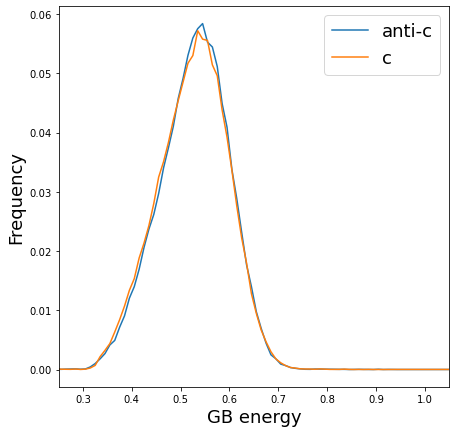

In [36]:
    freqArray_focus = freqArray_focus/np.sum(freqArray_focus)
    freqArray_unfocus = freqArray_unfocus/np.sum(freqArray_unfocus)

    plt.figure(figsize=(7,7))
    plt.plot(xCor, freqArray_focus, label='anti-c')
    plt.plot(xCor, freqArray_unfocus, label='c')
    plt.xlim([0.25,1.05])
    # plt.ylim([-0.15,0.15])
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
